<a href="https://colab.research.google.com/github/marynell-rg/Prediccion_gasto_turista/blob/master/Estimaci%C3%B3n_de_gasto_medio_por_turista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estimación de gasto medio por turista

Se busca predecir cuánto gastará un turista en su viaje en función de factores como país receptor, ingresos que genera el país por turismo, número de turistas que llegan, la inflación y el desempleo de dicho país. Lo caul permitirá a agencias de viajes, destinos turísticos y comercios locales personalizar ofertas y estrategias de precios según el país al que visitarán.

In [ ]:
#Importamos las librerías a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle

#Datos

## Obtención de Datos

In [ ]:
# Download latest version
path = kagglehub.dataset_download("bushraqurban/tourism-and-economic-impact")

print("Path to dataset files:", path)

100%|██████████| 270k/270k [00:00<00:00, 59.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/bushraqurban/tourism-and-economic-impact/versions/1


In [ ]:
#file_path ='/root/.cache/kagglehub/datasets/bushraqurban/tourism-and-economic-impact/versions/1/world_tourism_economy_data.csv'

file_path = path + '/world_tourism_economy_data.csv'
data = pd.read_csv(file_path)

data.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,7.820000e+08,9.720000e+05,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,8.034209e+09,1.530938e+07,12.204030,NaN,7.760536,2.654293e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,1.443613e+09,3.897975e+06,3.974476,NaN,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,3.100000e+07,4.500000e+04,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN


In [ ]:
# Guardar datos originales en csv

data_tourism_original = data.copy()
data_tourism_original.to_csv('data_tourism_original.csv', index=False)


##Descripción de los atributos

✔ **country**: país.

✔ **country_code**: código correspondiente al país.

✔ **year**: año.

✔ **tourism_receipts**: Ingresos totales que un país genera a partir del turismo internacional, medidos en dólares estadounidenses actuales.

✔ **tourism_arrivals**: Número total de turistas internacionales que llegan a un país, medido en cantidad.

✔ **tourism_expenditures**: Monto de dinero gastado por turistas internacionales dentro del país, medido en dólares estadounidenses actuales.

✔ **tourism_exports**: Porcentaje del total de exportaciones de un país que proviene de ingresos por turismo internacional.

✔ **tourism_departures**: Número de ciudadanos o residentes de un país que viajan al extranjero por motivos turísticos.

✔ **gdp**: Valor total de todos los bienes y servicios producidos en un país, expresado en dólares estadounidenses actuales.

✔ **inflation**: Cambio porcentual anual en el precio promedio de bienes y servicios en un país.

✔ **unemployment**: Porcentaje de personas dentro de la fuerza laboral que están desempleadas pero buscan empleo activamente.

#Analisis Exploratorio de los Datos

##Información sobre el Dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               6650 non-null   object 
 1   country_code          6650 non-null   object 
 2   year                  6650 non-null   int64  
 3   tourism_receipts      4289 non-null   float64
 4   tourism_arrivals      4949 non-null   float64
 5   tourism_exports       4114 non-null   float64
 6   tourism_departures    2589 non-null   float64
 7   tourism_expenditures  4173 non-null   float64
 8   gdp                   6424 non-null   float64
 9   inflation             5668 non-null   float64
 10  unemployment          3658 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 571.6+ KB


##Analítica descriptiva de los datos

In [ ]:
data.describe()

,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
count,6650.000000,4.289000e+03,4.949000e+03,4114.000000,2.589000e+03,4173.000000,6.424000e+03,5668.000000,3658.000000
mean,2011.000000,3.062956e+10,6.263894e+07,15.506851,8.246093e+07,6.652740,2.089999e+12,6.319369,7.961191
std,7.211645,1.291076e+11,2.049444e+08,17.758374,2.064665e+08,4.071632,7.761985e+12,18.682769,5.802565
min,1999.000000,1.000000e+05,9.000000e+02,0.000956,2.000000e+03,0.157818,1.396473e+07,-16.859691,0.039000
25%,2005.000000,2.690000e+08,5.290000e+05,4.657732,1.051000e+06,4.074702,6.087182e+09,1.865425,4.250000
50%,2011.000000,1.553000e+09,2.508000e+06,8.306797,4.634000e+06,5.754790,3.681803e+10,3.629433,6.548000
75%,2017.000000,9.144227e+09,1.818000e+07,18.506710,4.508703e+07,7.985102,4.266977e+11,6.563197,9.894692
max,2023.000000,1.863069e+12,2.403074e+09,101.966999,2.034432e+09,28.192276,1.061717e+14,557.201817,57.000000


Para saber cuantos paises diferentes tenemos:

In [ ]:
num_countries = data['country'].nunique()
print(f"Hay {num_countries} países diferentes en el dataset.")

Hay 266 países diferentes en el dataset.


Para nuestro problema en particular, utilizaremos sólo algunas variables del dataset. Para estimar el gasto promedio de un turista en un pais, nos quedaremos con los siguientes atributos:


1.   country
2.   country_code
3.   year
4.   tourism_arrivals
5.   tourism_expenditures

Tambien tomaremos en cuenta para nuestro estudio:

6.   gdp
7.   inflation
8.   unemployment

##Visualización de las distribuciones por país

In [ ]:
def verificar_pais_en_dataset(data, nombre_pais):
  """
  Verifica si un país dado mediante input está presente en el dataset.

  Args:
    data: DataFrame de Pandas que contiene los datos, incluyendo la columna 'country_code'.
    nombre_pais: Nombre del país a buscar.

  Returns:
    True si el país está en el dataset, False en caso contrario.
  """
  return nombre_pais in data['country'].values

while True:
  nombre_pais_input = input("Introduce el nombre del país: ")
  if verificar_pais_en_dataset(data, nombre_pais_input):
    print(f"El país '{nombre_pais_input}' está en la base de datos.")
    break  # Salir del bucle si el país es válido
  else:
    print(f"El país '{nombre_pais_input}' no está en la base de datos. Inténtalo de nuevo.")

Introduce el nombre del país: Spain
El país 'Spain' está en la base de datos.


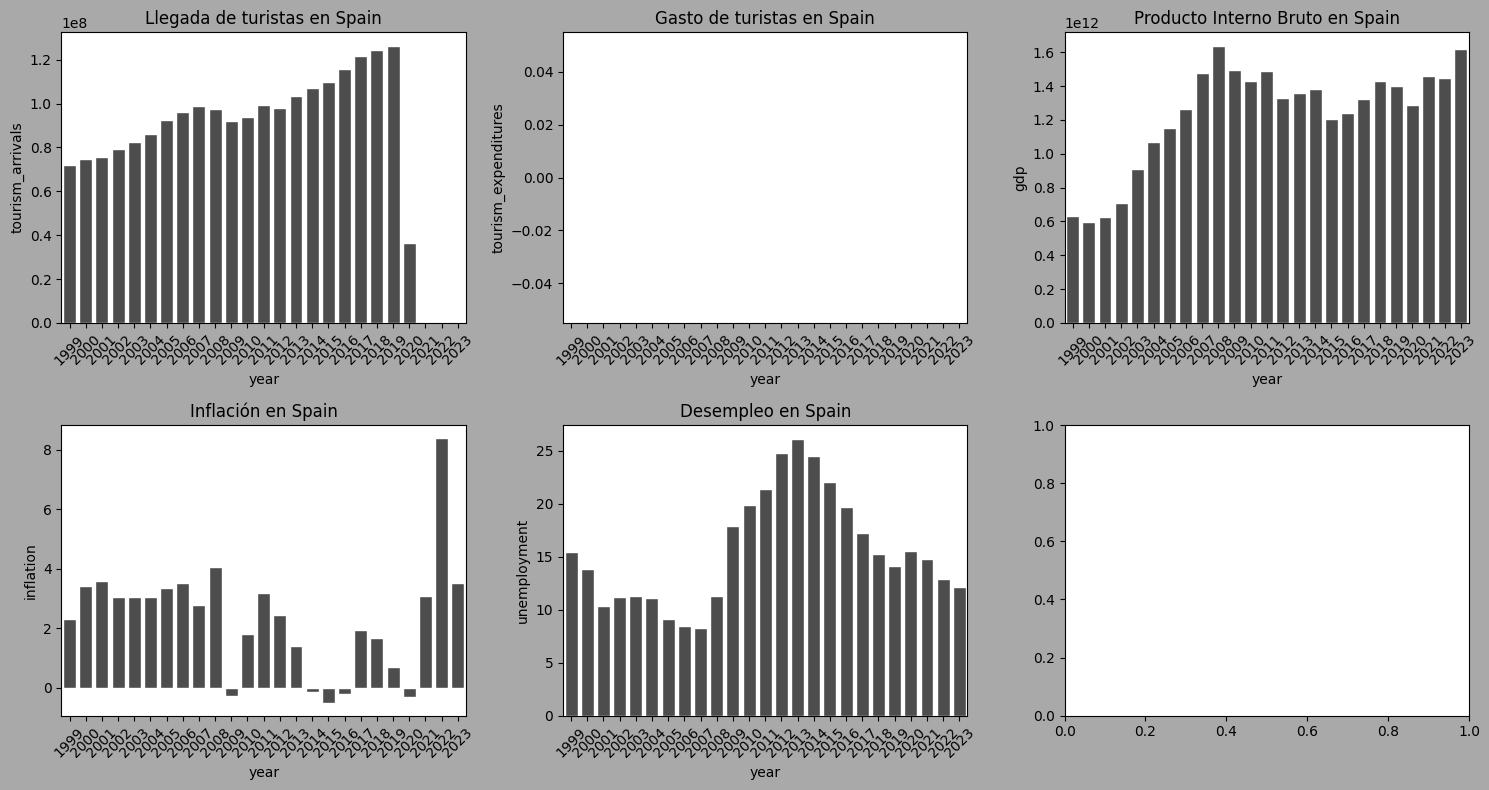

In [ ]:
# Definir las variables a graficar
variables_y = ['tourism_arrivals', 'tourism_expenditures', 'gdp',	'inflation',	'unemployment']
titulos = ['Llegada de turistas', 'Gasto de turistas', 'Producto Interno Bruto', 'Inflación', 'Desempleo']

# Crear una figura con 6 subplots (2 fila, 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), facecolor='darkgrey')

# Aplanar el array de ejes para iterar fácilmente
axes = axes.flatten()

# Iterar sobre las variables y crear los gráficos
sns.set_style("whitegrid", {'axes.facecolor': '0.5'})

for i, variable_y in enumerate(variables_y):
    sns.barplot(x='year', y=variable_y, data=data[data['country'] == nombre_pais_input], ax=axes.ravel()[i], color='0.3')
    axes.ravel()[i].set_title(f'{titulos[i]} en {nombre_pais_input}')
    axes.ravel()[i].tick_params(axis='x', rotation=45)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

No hay datos sobre cuanto gastaron los turistas en España durante el periodo en estudio. Por lo que, tampoco sabremos cuanto fue el gasto promedio por turista en España durante el período estudiado

Afortunadamente, como Agencia de Viajes, nuestro objetivo no es saber cuanto gastaron los turistas en España, si no, cuanto gastarán los españoles que visitarán otros paises en el futuro (nuestros clientes potenciales).

##Visualización de las distribuciones de cada variable

In [ ]:
#Visualización de las distribuciones

def histograma(data, variable, titulo, ax):
  """
  Genera un histograma para una variable dada.

  Args:
    data: DataFrame de Pandas que contiene los datos.
    variable: Nombre de la columna (variable) a visualizar.
  """
  sns.histplot(data=data, x=variable, kde=True, ax=ax, color='0.3')
  ax.set_title(titulo)
  ax.set_xlabel(variable)
  ax.set_ylabel("Frecuencia")

print('Función visualizar_histograma creada exitosamente')

Función visualizar_histograma creada exitosamente


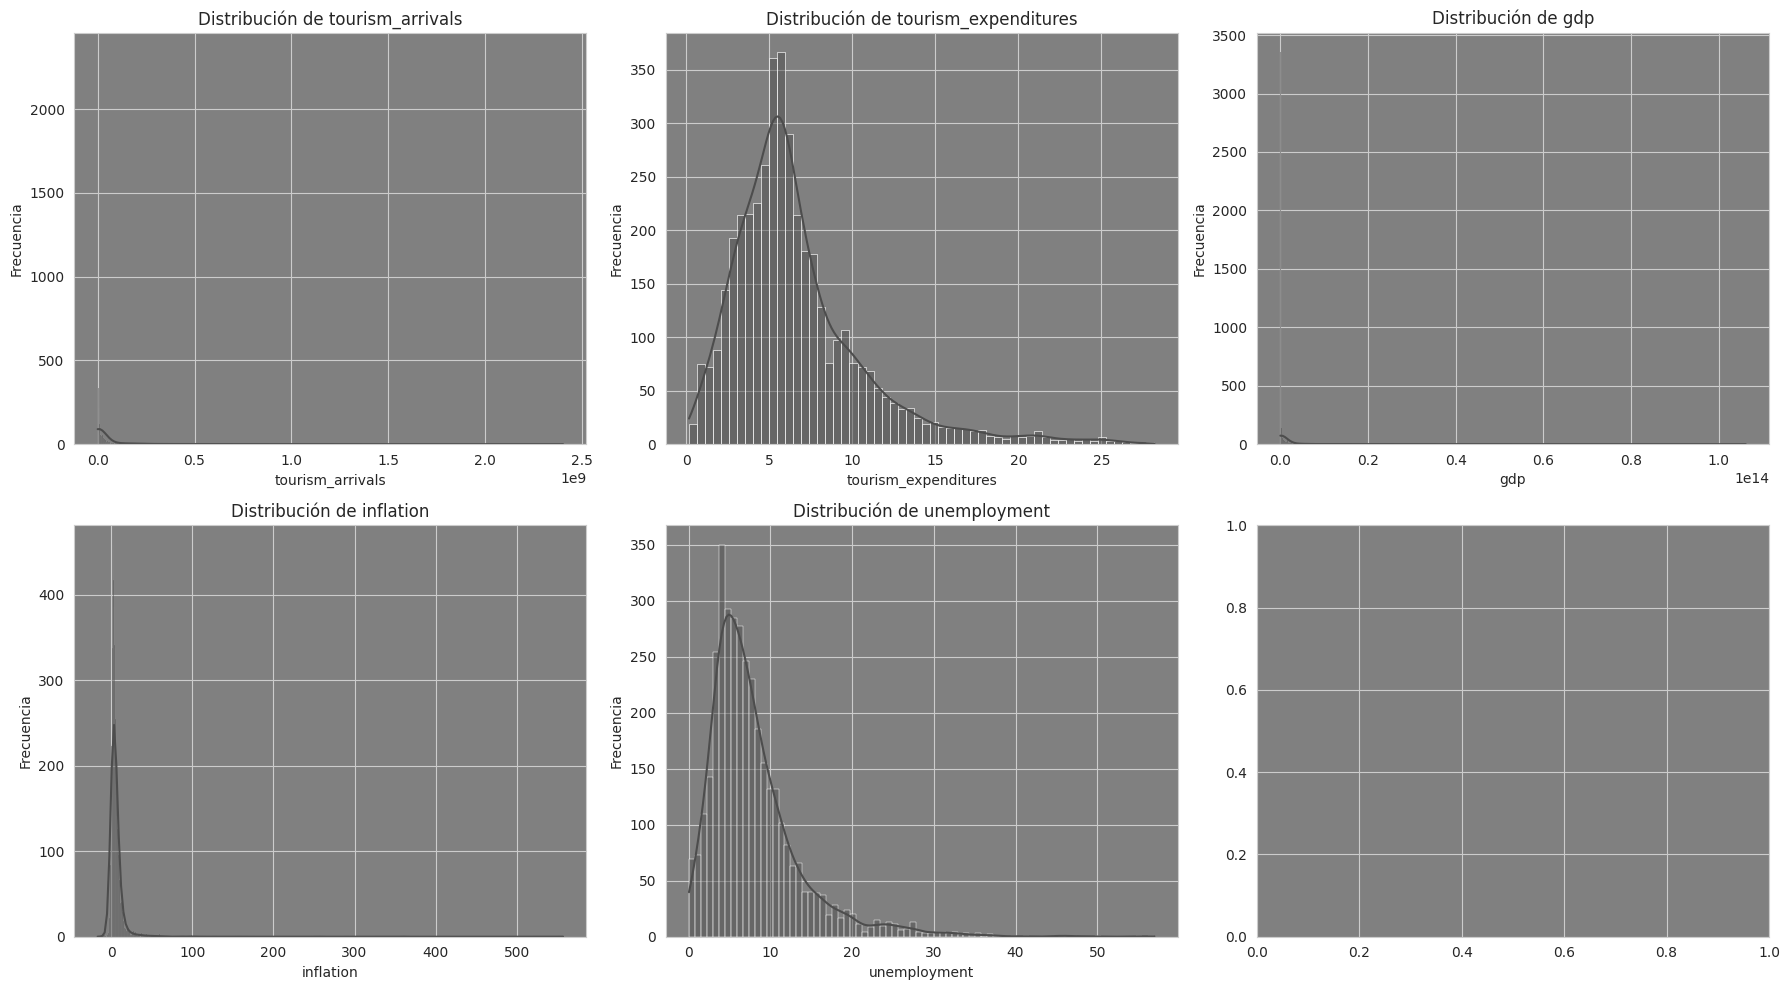

In [ ]:
# Lista de variables a visualizar
variables_a_graficar = ['tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
titulos_histogramas = ['Distribución de tourism_arrivals', 'Distribución de tourism_expenditures', 'Distribución de gdp', 'Distribución de inflation', 'Distribución de unemployment']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes = axes.flatten()

# Generar los histogramas para cada variable
for i, variable in enumerate(variables_a_graficar):
    histograma(data, variable, titulos_histogramas[i], axes[i])

plt.tight_layout()
plt.show()

Estos gráficos nos muestran que hay una diferencia grande estre las escalas que estan los datos.

## Visualización de cada variable en un gráfico de bigote

In [ ]:
def visualizar_boxplot(data, variable, titulo, ax):
  """
  Genera un gráfico de bigote (boxplot) para una variable dada.

  Args:
    data: DataFrame de Pandas que contiene los datos.
    variable: Nombre de la columna (variable) a visualizar.
    titulo: Título del gráfico.
  """
  sns.boxplot(y=variable, data=data, ax=ax, color='0.3')
  ax.set_title(titulo)
  ax.set_ylabel(variable)

print('Función creada exitosamente')

Función creada exitosamente


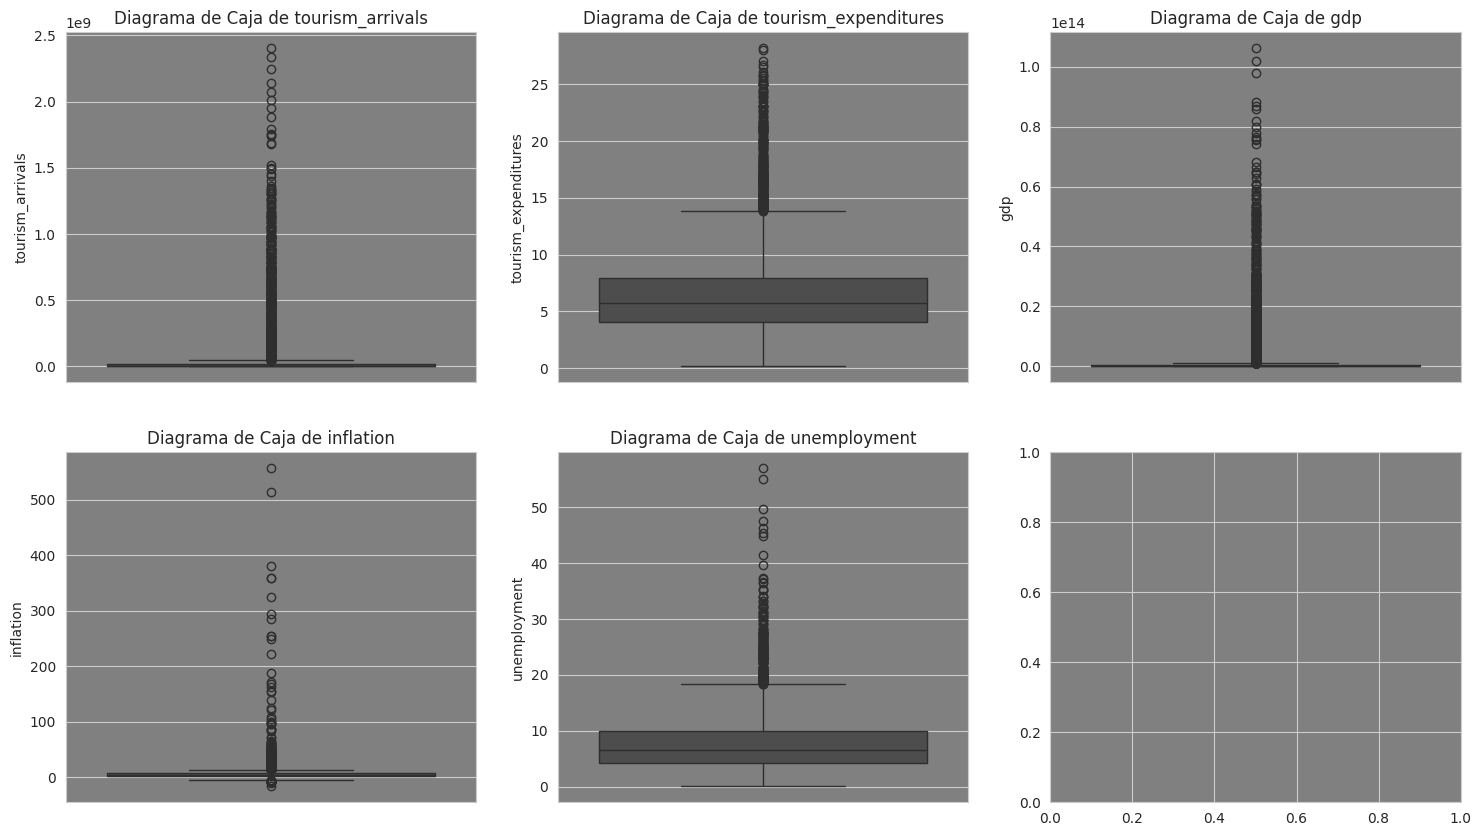

In [ ]:
# Lista de variables a visualizar
variables_a_graficar_boxplot = ['tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
titulos_boxplot = ['Diagrama de Caja de tourism_arrivals', 'Diagrama de Caja de tourism_expenditures', 'Diagrama de Caja de gdp', 'Diagrama de Caja de inflation', 'Diagrama de Caja de unemployment']

fig_boxplot, axes_boxplot = plt.subplots(2, 3, figsize=(18, 10))
axes_boxplot = axes_boxplot.flatten()

# Generar los diagramas de caja para cada variable usando la función
for i, variable in enumerate(variables_a_graficar_boxplot):
    visualizar_boxplot(data, variable, titulos_boxplot[i], axes_boxplot[i])

Los gráficos de caja muestran que hay muchos valores fuera de serie en diferentes variables.

## Top paises en los que el gasto por turismo fue mayor

Nos interesa saber, cuales fueron los 10 países que recibieron mas turistas internacionales en los últimos años

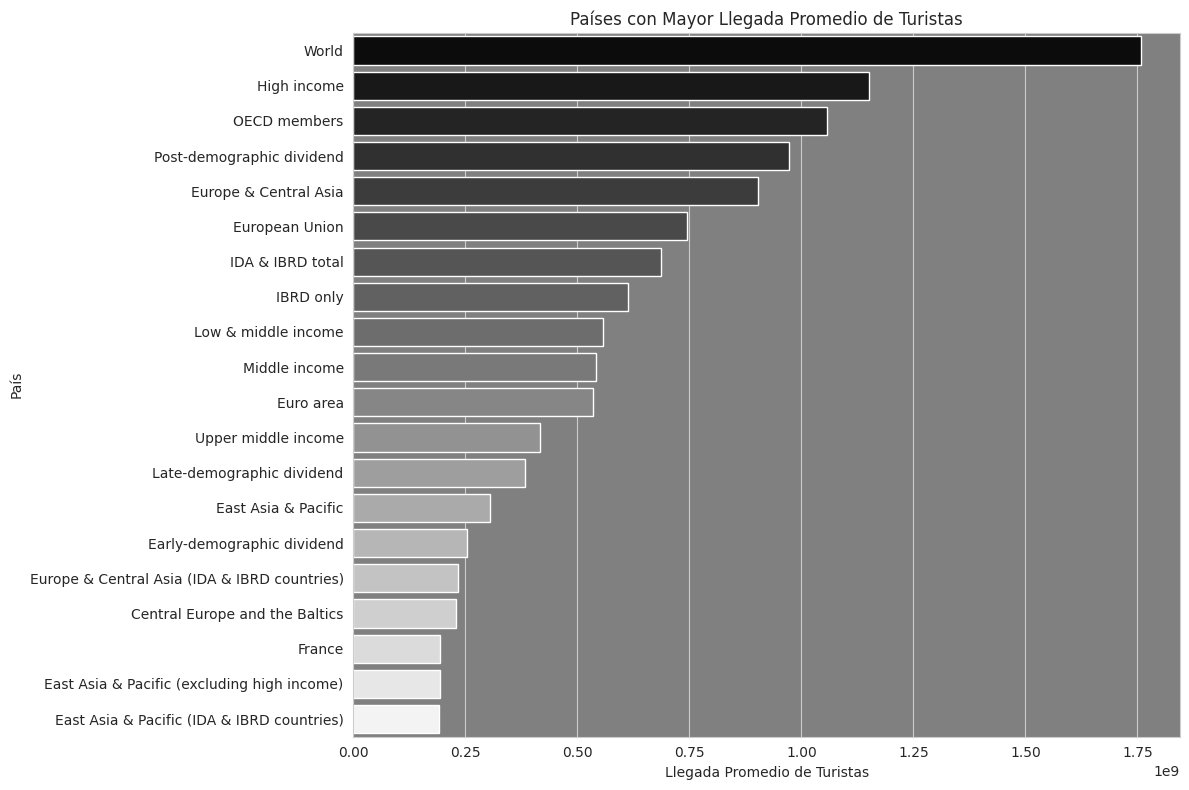

In [ ]:
# Calcular la llegada promedio por turista para cada país en todo el periodo
llegada_prom_pais = data.groupby('country')['tourism_arrivals'].mean().reset_index()

# Ordenar los países por gasto promedio descendente (de mayor a menor
top_paises = llegada_prom_pais.sort_values('tourism_arrivals', ascending=False).head(20)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='tourism_arrivals', y='country', data=top_paises, palette='binary_r', hue='country', legend=False)
plt.title('Países con Mayor Llegada Promedio de Turistas')
plt.xlabel('Llegada Promedio de Turistas')
plt.ylabel('País')
plt.tight_layout()
plt.show()

# Preparación de los datos

## Crear copia del Dataset

Como primer paso, crearemos un nuevo Dataset que concentre las variables que necesitamos para el estudio.

In [ ]:
data_tourism = data[['country', 'country_code', 'year', 'tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']].copy()
data_tourism.head()

,country,country_code,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,NaN


Como hay muchos valores NaN, en diferentes atributos y países, eliminarlos no es una opción viable, por lo que los reemplazaremos con la media de los valores existentes, con la finalidad de mantener la distribución correspondiente.

In [ ]:
# Reemplazar los valores nulos con la media de cada variable, por cada país

for pais in data_tourism['country'].unique():
    for columna in ['tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']:
        media_pais = data_tourism[data_tourism['country'] == pais][columna].mean()
        data.loc[(data_tourism['country'] == pais) & (data_tourism[columna].isnull()), columna] = media_pais

print('Valores Nulos imputados')

Valores Nulos imputados


In [ ]:
#Eliminamos duplicados

data_tourism = data_tourism.drop_duplicates()

Visualizamos el data frame con los valores nulos imputados y los duplicados eliminados.

In [ ]:
# Mostrar las primeras columnas del nuevo data frame
data_tourism.head()

,country,country_code,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,NaN


Observamos en el resultado anterior que hay paises cuya información sobre la llegada de turistas, sigue apareciendo como NaN, en este caso, asumiremos que la llegada de turistas a esos paises es despreciable, por lo que procederemos a eliminar las filas correspondientes

In [ ]:
# Eliminar filas con valores NaN en la columna 'tourism_arrivals'
data_tourism.dropna(subset=['tourism_arrivals'], inplace=True)

print('Filas con valores NaN en tourism_arrivals eliminadas.')

Filas con valores NaN en tourism_arrivals eliminadas.


In [ ]:
data_tourism.head()

,country,country_code,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,NaN
3,Africa Western and Central,AFW,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,NaN
5,Albania,ALB,1999,3.710000e+05,3.699007,3.212122e+09,0.389438,18.4


In [ ]:
data_tourism.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 0 to 5851
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               4949 non-null   object 
 1   country_code          4949 non-null   object 
 2   year                  4949 non-null   int64  
 3   tourism_arrivals      4949 non-null   float64
 4   tourism_expenditures  3826 non-null   float64
 5   gdp                   4889 non-null   float64
 6   inflation             4454 non-null   float64
 7   unemployment          2993 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 348.0+ KB


Antes de decidir que conducta tomar respecto a los valores NaN que aún se encuentran en nuestros datos, eliminaremos los outliers de una de las variables criticas 'tourism arrivals'

In [ ]:
def eliminar_outliers_iqr(data, variable):
    """
    Elimina los outliers de una variable en un DataFrame usando el rango intercuartílico (IQR).

    Args:
        data: DataFrame de Pandas que contiene los datos.
        variable: Nombre de la columna (variable) a la que se le eliminarán los outliers.

    Returns:
        DataFrame de Pandas con los outliers eliminados.
    """

    # Calcula los cuartiles Q1 y Q3
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)

    # Calcula el rango intercuartílico (IQR)
    IQR = Q3 - Q1

    # Define los límites superior e inferior para identificar outliers
    limite_superior = Q3 + 1.5 * IQR
    limite_inferior = Q1 - 1.5 * IQR

    # Filtra el DataFrame para eliminar los outliers
    data_sin_outliers = data[(data[variable] >= limite_inferior) & (data[variable] <= limite_superior)]

    return data_sin_outliers

print('Función creada exitosamente')

Función creada exitosamente


In [ ]:
#Eliminar los outliers correspondientes a la variable tourism_arrival
data_sin_outliers = eliminar_outliers_iqr(data_tourism, 'tourism_arrivals').copy()

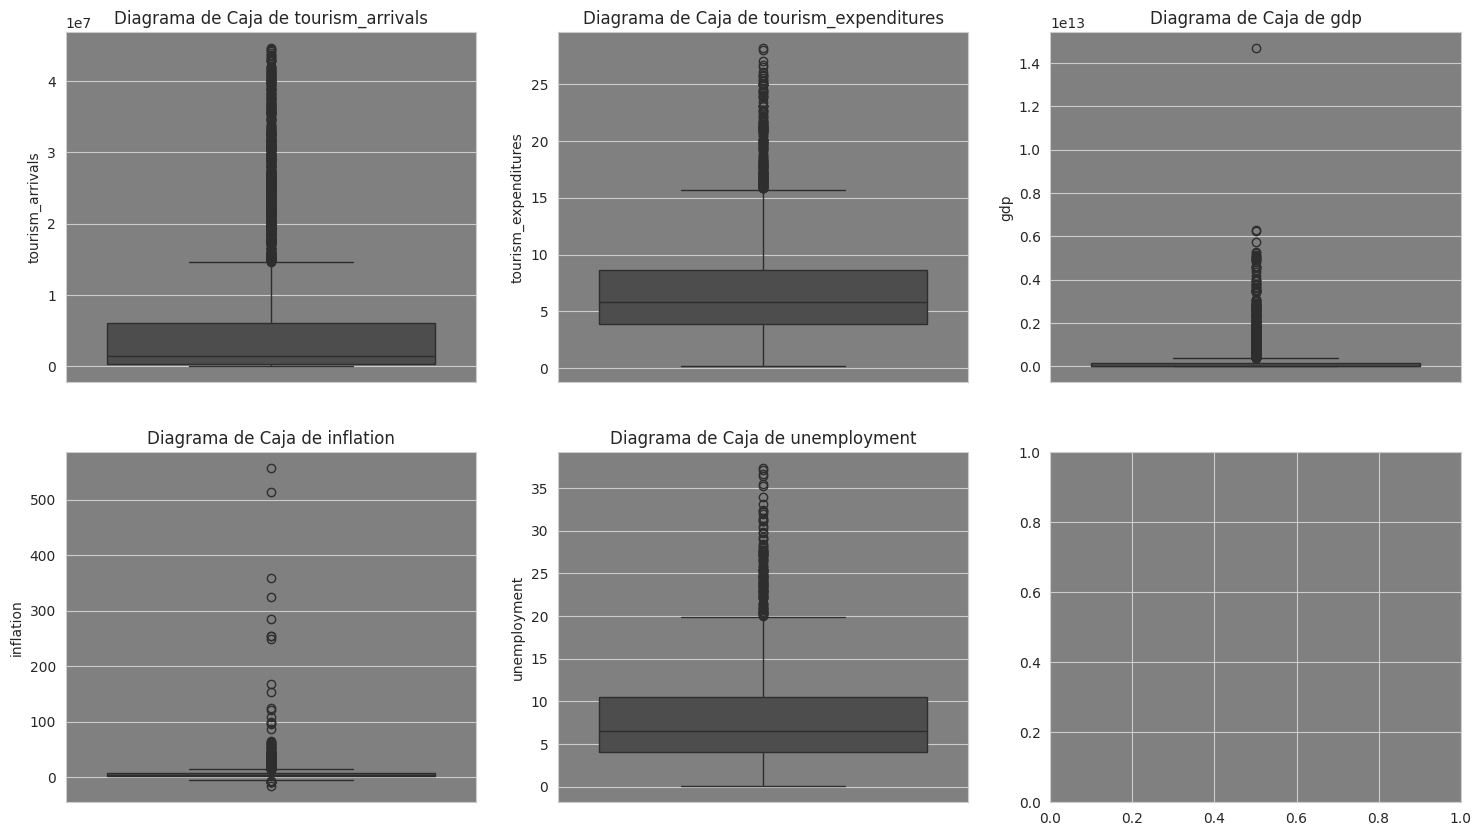

In [ ]:
# Lista de variables a visualizar
variables_a_graficar_boxplot_nout = ['tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
titulos_boxplot_nout = ['Diagrama de Caja de tourism_arrivals', 'Diagrama de Caja de tourism_expenditures', 'Diagrama de Caja de gdp', 'Diagrama de Caja de inflation', 'Diagrama de Caja de unemployment']

fig_boxplot, axes_boxplot = plt.subplots(2, 3, figsize=(18, 10))
axes_boxplot = axes_boxplot.flatten()

# Generar los diagramas de caja para cada variable usando la función
for i, variable in enumerate(variables_a_graficar_boxplot_nout):
    visualizar_boxplot(data_sin_outliers, variable, titulos_boxplot_nout[i], axes_boxplot[i])

In [ ]:
data_sin_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4140 entries, 0 to 5851
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               4140 non-null   object 
 1   country_code          4140 non-null   object 
 2   year                  4140 non-null   int64  
 3   tourism_arrivals      4140 non-null   float64
 4   tourism_expenditures  3179 non-null   float64
 5   gdp                   4080 non-null   float64
 6   inflation             3645 non-null   float64
 7   unemployment          2352 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 291.1+ KB


In [ ]:
data_sin_outliers.head()

,country,country_code,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,NaN
3,Africa Western and Central,AFW,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,NaN
4,Angola,AGO,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,NaN
5,Albania,ALB,1999,3.710000e+05,3.699007,3.212122e+09,0.389438,18.4


Se presume que los valores NaN que aún quedan en el data set se deben a que no hay información para la variable dada en el país dado, por lo que esta falta de información la reemplazaremos con la media de los datos generales.

In [ ]:
# Reemplazar los valores nulos con la media de cada columna
for columna in data_sin_outliers.columns:
    if data_sin_outliers[columna].isnull().any():
        media_columna = data_sin_outliers[columna].mean()
        data_sin_outliers.fillna({columna : media_columna}, inplace=True)

print('Valores Nulos imputados con la media de cada columna.')

Valores Nulos imputados con la media de cada columna.


In [ ]:
# Renombrar Data Set

data_tourism_clean = data_sin_outliers

In [ ]:
data_tourism_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4140 entries, 0 to 5851
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               4140 non-null   object 
 1   country_code          4140 non-null   object 
 2   year                  4140 non-null   int64  
 3   tourism_arrivals      4140 non-null   float64
 4   tourism_expenditures  4140 non-null   float64
 5   gdp                   4140 non-null   float64
 6   inflation             4140 non-null   float64
 7   unemployment          4140 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 291.1+ KB


Ahora, nuestros datos estan limpios y listos para usar

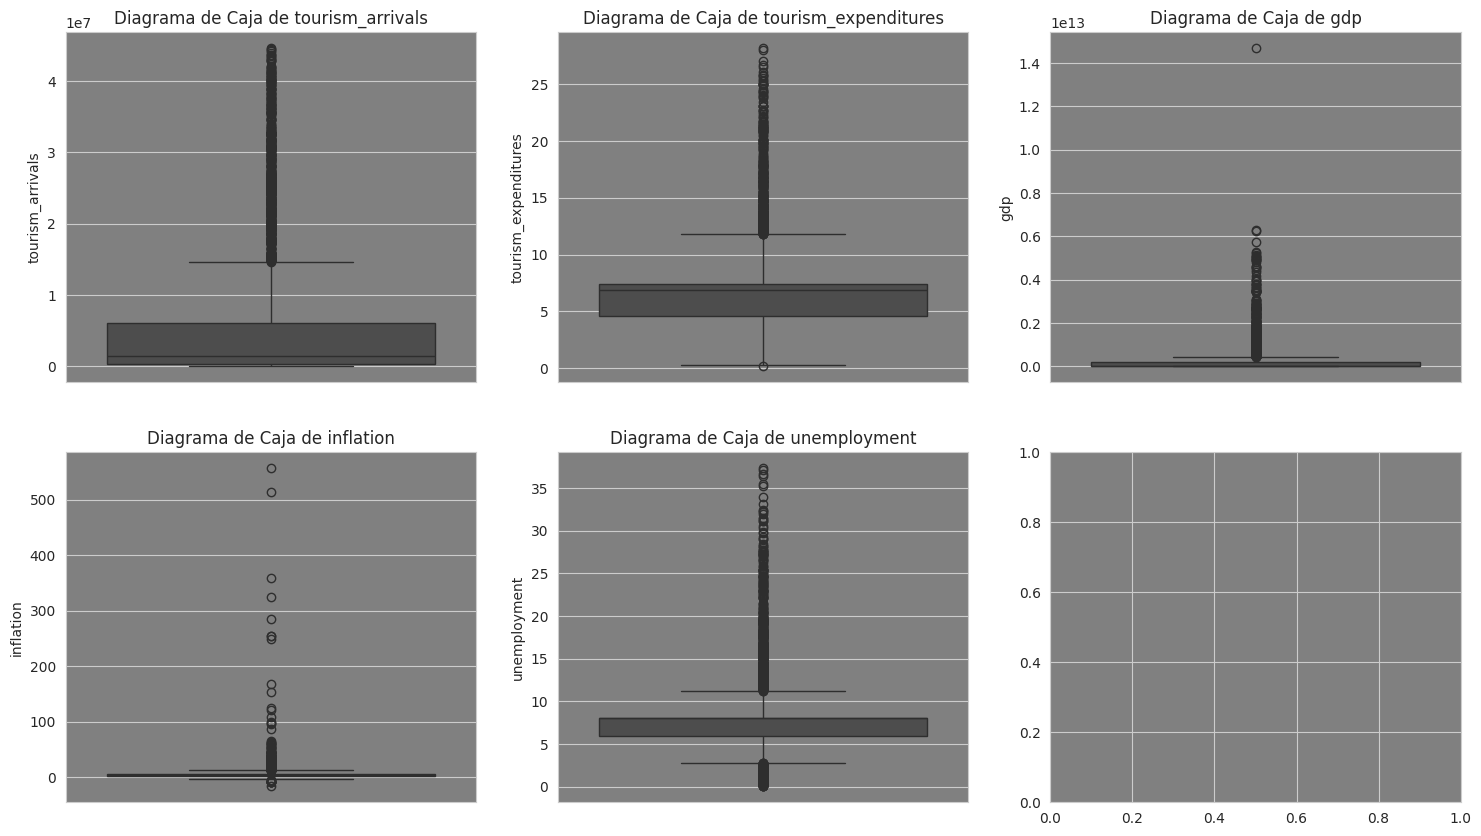

In [ ]:
fig_boxplot, axes_boxplot = plt.subplots(2, 3, figsize=(18, 10))
axes_boxplot = axes_boxplot.flatten()

# Generar los diagramas de caja para cada variable usando la función
for i, variable in enumerate(variables_a_graficar_boxplot_nout):
    visualizar_boxplot(data_tourism_clean, variable, titulos_boxplot_nout[i], axes_boxplot[i])

Los gráficos de cajas, sigen mostrando distribuciones no normales, por lo que procederemos a estandarizar nuestras variables mas adelante.

## Crear nueva tabla con los códigos de los paises

Para estudiar el gasto promedio de los turistas que llegan a un país, creamos una nueva columna que llamaremos "tourism_expenditures_mean"

In [ ]:
# Crear una nueva columna 'tourism_expenditures_mean'
data_tourism_clean['tourism_expenditures_mean'] = data_tourism_clean['tourism_expenditures'] / data_tourism_clean['tourism_arrivals']

# Reemplazar valores infinitos (divisiones por cero) con 0 (Sí los hay)
data_tourism_clean.replace([np.inf, -np.inf], 0, inplace=True)

 # Reemplazar valores NaN con 0
data_tourism_clean['tourism_expenditures_mean'] = data_tourism_clean['tourism_expenditures_mean'].fillna(0)

data_tourism_clean.head()

,country,country_code,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment,tourism_expenditures_mean
0,Aruba,ABW,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,8.06145,9.768917e-06
1,Africa Eastern and Southern,AFE,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,8.06145,5.069139e-07
3,Africa Western and Central,AFW,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,8.06145,1.577047e-06
4,Angola,AGO,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,8.06145,5.532529e-05
5,Albania,ALB,1999,3.710000e+05,3.699007,3.212122e+09,0.389438,18.40000,9.970368e-06


## Generar nueva tabla con los nombres de los paises codificados en números

Para trabajar con Machine Learning, debemos tener todos nuestros datos en formato numérico, por lo que le asignaremos un código a nuestros paises bajo estudio. Con lo cual tendremos una tabla alternativa, que nos permitirá consultar los códigos de los países mas adelante

In [ ]:
# Crear un nuevo DataFrame con la columna 'country'
country_codes_num = pd.DataFrame({'country': data_tourism_clean['country'].unique()})

# Agregar una columna 'code_num' con números desde 1 hasta el último país, formateados con 3 dígitos
country_codes_num['code_num'] = [str(i).zfill(3) for i in range(1, len(country_codes_num) + 1)]

# Mostrar el nuevo DataFrame
print(country_codes_num)

                         country code_num
0                          Aruba      001
1    Africa Eastern and Southern      002
2     Africa Western and Central      003
3                         Angola      004
4                        Albania      005
..                           ...      ...
213         United Arab Emirates      214
214                   Madagascar      215
215                        China      216
216                        Spain      217
217                        Italy      218

[218 rows x 2 columns]


In [ ]:
# Guardar la tabla en .CSV

country_codes_num.to_csv('country_codes_num.csv', index=False)
print('Tabla guardada en .CSV exitosamente')

Tabla guardada en .CSV exitosamente


Ya que tenemos cada país asociado a un códig numérico, procedemos a sustituir las columnas con los nombres respectivos y a eliminar de nuestro dataframe las columnas country y code_country

In [ ]:
# Fusionar data_tourism_clean con country_codes_num usando 'country' como clave
data_tourism_final = pd.merge(data_tourism_clean, country_codes_num, on='country', how='left')

# Eliminar las columnas 'country' y 'country_code'
data_tourism_final.drop(['country', 'country_code'], axis=1, inplace=True)

# Obtener la lista de columnas
cols = list(data_tourism_final.columns)

# Mover 'code_num' al principio de la lista
cols.insert(0, cols.pop(cols.index('code_num')))

# Reordenar las columnas del DataFrame
data_tourism_final = data_tourism_final.reindex(columns=cols)

# Mostrar el DataFrame actualizado
print(data_tourism_final.head())

  code_num  year  tourism_arrivals  tourism_expenditures           gdp  \
0      001  1999      9.720000e+05              9.495387  1.722905e+09   
1      002  1999      1.530938e+07              7.760536  2.654293e+11   
2      003  1999      3.897975e+06              6.147291  1.394683e+11   
3      004  1999      4.500000e+04              2.489638  6.152923e+09   
4      005  1999      3.710000e+05              3.699007  3.212122e+09   

    inflation  unemployment  tourism_expenditures_mean  
0    2.280372       8.06145               9.768917e-06  
1    7.819865       8.06145               5.069139e-07  
2    0.372266       8.06145               1.577047e-06  
3  248.195902       8.06145               5.532529e-05  
4    0.389438      18.40000               9.970368e-06  


In [ ]:
# Convertir la columna 'code_num' a tipo entero (int64)
data_tourism_final['code_num'] = data_tourism_final['code_num'].astype('int64')
data_tourism_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_num                   4140 non-null   int64  
 1   year                       4140 non-null   int64  
 2   tourism_arrivals           4140 non-null   float64
 3   tourism_expenditures       4140 non-null   float64
 4   gdp                        4140 non-null   float64
 5   inflation                  4140 non-null   float64
 6   unemployment               4140 non-null   float64
 7   tourism_expenditures_mean  4140 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 258.9 KB


In [ ]:
data_tourism_final.head()

,code_num,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment,tourism_expenditures_mean
0,1,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,8.06145,9.768917e-06
1,2,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,8.06145,5.069139e-07
2,3,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,8.06145,1.577047e-06
3,4,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,8.06145,5.532529e-05
4,5,1999,3.710000e+05,3.699007,3.212122e+09,0.389438,18.40000,9.970368e-06


Ahora sí lo tenemos, todas nuestras columnas tienen datos numericos. Esto nos permite seguir con la próxima parte del proyecto

##Transformación logaritmica de variables

In [ ]:
# Aplicar transformación logarítmica a todas las variables

columns_to_log = ['tourism_arrivals', 'tourism_expenditures', 'gdp', 'unemployment']
for col in columns_to_log:
    data_tourism_final[f'{col}_log'] = np.log1p(data_tourism_final[col])

# Dataset con la nueva columna transformada
data_tourism_final.head()

,code_num,year,tourism_arrivals,tourism_expenditures,gdp,inflation,unemployment,tourism_expenditures_mean,tourism_arrivals_log,tourism_expenditures_log,gdp_log,unemployment_log
0,1,1999,9.720000e+05,9.495387,1.722905e+09,2.280372,8.06145,9.768917e-06,13.787112,2.350936,21.267278,2.204029
1,2,1999,1.530938e+07,7.760536,2.654293e+11,7.819865,8.06145,5.069139e-07,16.543976,2.170257,26.304614,2.204029
2,3,1999,3.897975e+06,6.147291,1.394683e+11,0.372266,8.06145,1.577047e-06,15.175968,1.966733,25.661104,2.204029
3,4,1999,4.500000e+04,2.489638,6.152923e+09,248.195902,8.06145,5.532529e-05,10.714440,1.249798,22.540193,2.204029
4,5,1999,3.710000e+05,3.699007,3.212122e+09,0.389438,18.40000,9.970368e-06,12.823960,1.547351,21.890198,2.965273


Visualización de la distribución de las variables transformadas

In [ ]:
# Creamos un nuevo dataset con las columnas transformadas

columnas_deseadas = ['code_num',	'year', 'tourism_arrivals_log',	\
                     'tourism_expenditures_log',	'gdp_log',	'unemployment_log',\
                     'tourism_expenditures_mean']

data_tourism_ = data_tourism_final[columnas_deseadas].copy()
data_tourism_.head()

,code_num,year,tourism_arrivals_log,tourism_expenditures_log,gdp_log,unemployment_log,tourism_expenditures_mean
0,1,1999,13.787112,2.350936,21.267278,2.204029,9.768917e-06
1,2,1999,16.543976,2.170257,26.304614,2.204029,5.069139e-07
2,3,1999,15.175968,1.966733,25.661104,2.204029,1.577047e-06
3,4,1999,10.714440,1.249798,22.540193,2.204029,5.532529e-05
4,5,1999,12.823960,1.547351,21.890198,2.965273,9.970368e-06


In [ ]:
data_tourism_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_num                   4140 non-null   int64  
 1   year                       4140 non-null   int64  
 2   tourism_arrivals_log       4140 non-null   float64
 3   tourism_expenditures_log   4140 non-null   float64
 4   gdp_log                    4140 non-null   float64
 5   unemployment_log           4140 non-null   float64
 6   tourism_expenditures_mean  4140 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 226.5 KB


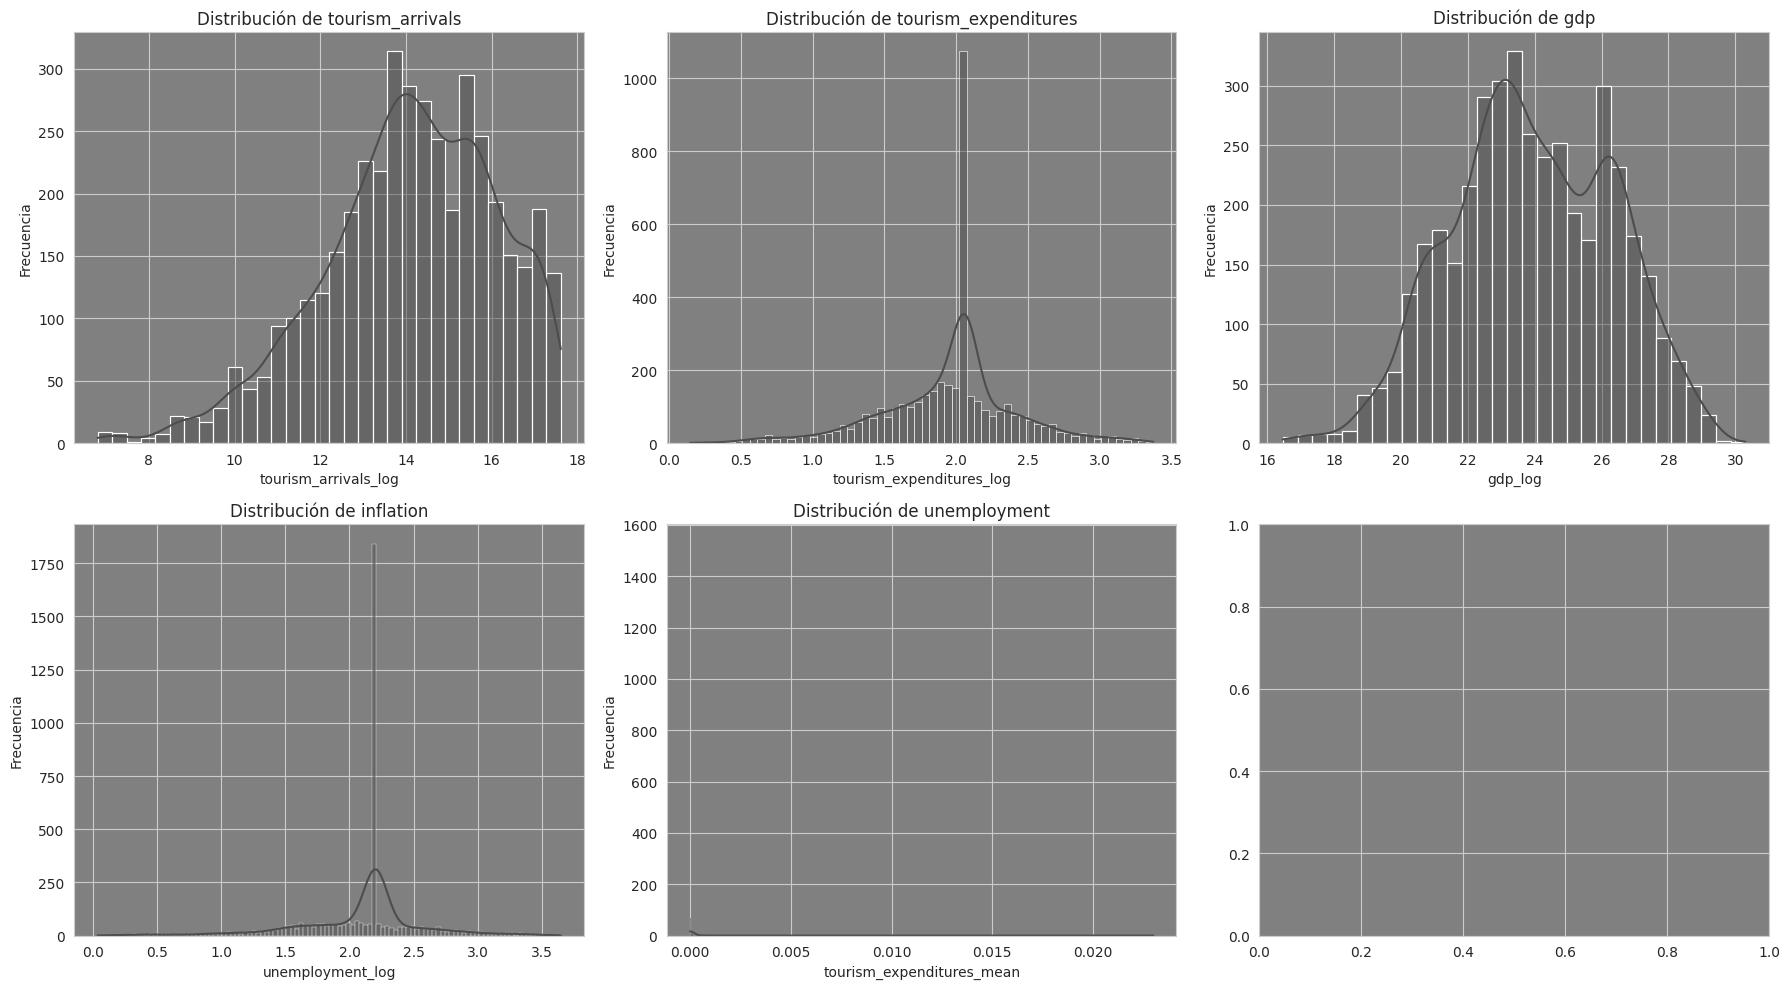

In [ ]:
# Lista de variables a visualizar
variables_a_graficar_log = ['tourism_arrivals_log',	'tourism_expenditures_log',	'gdp_log',	'unemployment_log',	'tourism_expenditures_mean']
titulos_histogramas_log = ['Distribución de tourism_arrivals_log', 'Distribución de tourism_expenditures_log', 'Distribución de gdp_log', 'Distribución de unemployment_log', 'Distribución de tourism_expenditures_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes = axes.flatten()

# Generar los histogramas para cada variable
for i, variable in enumerate(variables_a_graficar_log):
    histograma(data_tourism_, variable, titulos_histogramas[i], axes[i])

plt.tight_layout()
plt.show()

## Estandarizar variables

In [ ]:
# Seleccionar las columnas numéricas a estandarizar (excluyendo 'code_num' y 'year')
columnas_a_estandarizar = ['tourism_arrivals_log',	'tourism_expenditures_log',	'gdp_log',	'unemployment_log']

# Crear un objeto StandardScaler
scaler = MinMaxScaler()

# Ajustar el scaler a los datos y transformar las columnas seleccionadas
data_tourism_[columnas_a_estandarizar] = scaler.fit_transform(data_tourism_[columnas_a_estandarizar])

# Mostrar el DataFrame con las columnas estandarizadas
print(data_tourism_.head())

   code_num  year  tourism_arrivals_log  tourism_expenditures_log   gdp_log  \
0         1  1999              0.646010                  0.683033  0.347269   
1         2  1999              0.901030                  0.627050  0.710557   
2         3  1999              0.774484                  0.563988  0.664147   
3         4  1999              0.361776                  0.341845  0.439071   
4         5  1999              0.556914                  0.434042  0.392194   

   unemployment_log  tourism_expenditures_mean  
0          0.600317               9.768917e-06  
1          0.600317               5.069139e-07  
2          0.600317               1.577047e-06  
3          0.600317               5.532529e-05  
4          0.811321               9.970368e-06  


In [ ]:
# Descargar datos listos para usar

data_tourism_.to_csv('data_tourism_final.csv', index=False)

## Matriz de correlación

Ahora miraremos el gráfico de calor para saber si hay correlación estre las variables

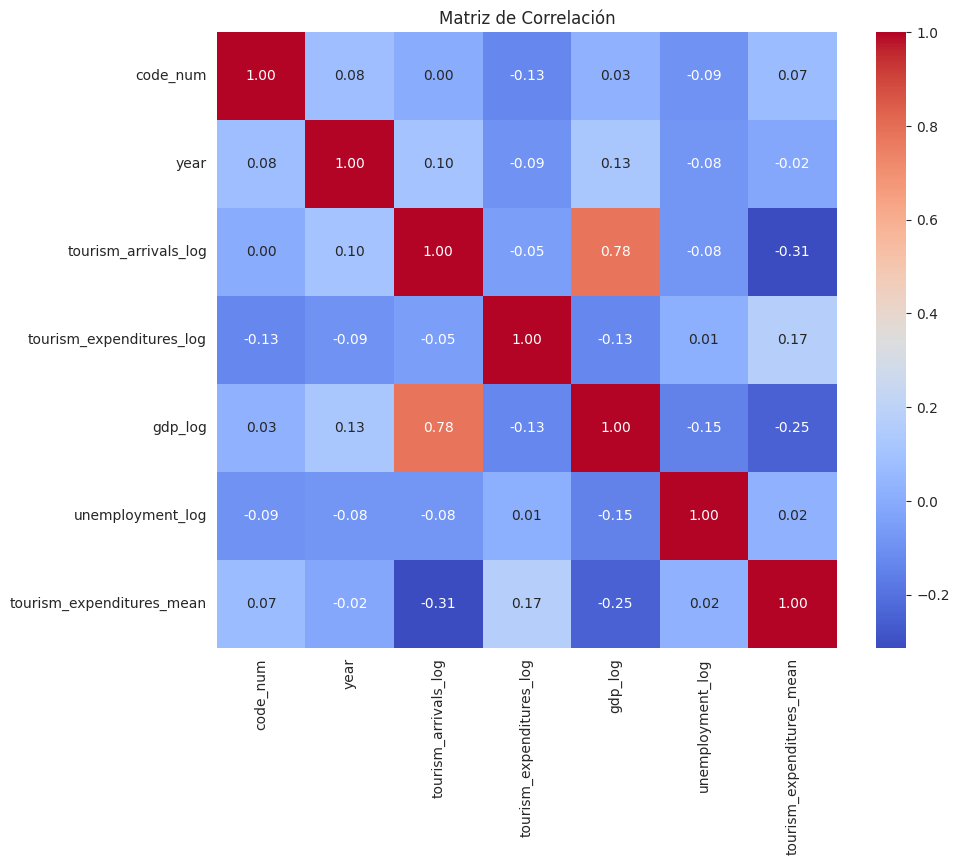

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = data_tourism_.corr()

# Crear el gráfico de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

De acuerdo a la matriz de correlación, la llegada de turistas tiene cierta correlación positiva con el producto interno bruto.

## Feature X vs Target Y

In [ ]:
# Separación de los dataframes en variables características y objetivo

X = data_tourism_.drop(columns= ['tourism_expenditures_mean'])
y = data_tourism_['tourism_expenditures_mean']

X.head()

,code_num,year,tourism_arrivals_log,tourism_expenditures_log,gdp_log,unemployment_log
0,1,1999,0.646010,0.683033,0.347269,0.600317
1,2,1999,0.901030,0.627050,0.710557,0.600317
2,3,1999,0.774484,0.563988,0.664147,0.600317
3,4,1999,0.361776,0.341845,0.439071,0.600317
4,5,1999,0.556914,0.434042,0.392194,0.811321


In [ ]:
y.head()

,tourism_expenditures_mean
0,9.768917e-06
1,5.069139e-07
2,1.577047e-06
3,5.532529e-05
4,9.970368e-06


## Train-Test Split

In [ ]:
#Dividir los datos en conjuntos de entrenamiento y pruebas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In [ ]:
# Selección de Características

test = SelectKBest(score_func=f_regression, k=4)
fit = test.fit(X_train, y_train)

X_train_selected = fit.transform(X_train)
X_test_selected = fit.transform(X_test)

#Entrenamiento de modelos de Machine Learning

## Definir lista de variables a utilizar

In [ ]:
# Crear listas para almacenar resultados

models = ['Gradient Boosting', 'Random Forest', 'XGBRegressoe', 'LassoCV', 'Linear Regression']
mae_scores = []
mse_scores = []
r2s_scores = []
rmse_scores = []
mape_scores = []

## Definir los modelos ML a utilizar

In [ ]:
# Definir modelos

GBRegression_model = GradientBoostingRegressor()
RF_model = RandomForestRegressor()
XGBRegression_model = XGBRegressor()
LassoCV_model = LassoCV()
LinearRegression_model = LinearRegression()

In [ ]:
# Lista de modelos

models_list = [GBRegression_model,
               RF_model,
               XGBRegression_model,
               LassoCV_model,
               LinearRegression_model]

## Entrenamiento de cada modelo utilizando validación cruzada

In [ ]:
# Entrenar y evaluar cada modelo utilizando validación cruzada

for model in models_list:
  mae_scores.append(cross_val_score(model, X_train_selected, y_train, scoring= 'neg_mean_absolute_error', cv=5).mean())
  mse_scores.append(cross_val_score(model, X_train_selected, y_train, scoring= 'neg_mean_squared_error', cv=5).mean())
  r2s_scores.append(cross_val_score(model, X_train_selected, y_train, scoring= 'r2', cv=5).mean())

## Resultados de las métricas de cada modelo entrenado

In [ ]:
results_df = pd.DataFrame({
    'Model': models,
    'neg_mean_absolute_error': mae_scores,
    'neg_mean_squared_error': mse_scores,
    'r2': r2s_scores
})

In [ ]:
# Mostrar los resultados

print(results_df)

               Model  neg_mean_absolute_error  neg_mean_squared_error  \
0  Gradient Boosting                -0.000015           -2.537251e-08   
1      Random Forest                -0.000017           -3.654241e-08   
2       XGBRegressoe                -0.000034           -6.629242e-08   
3            LassoCV                -0.000302           -8.942744e-07   
4  Linear Regression                -0.000323           -8.944304e-07   

         r2  
0  0.977920  
1  0.964754  
2  0.943815  
3  0.122104  
4  0.116686  


Los modelos que arrojaron mejores resultados fueron:

1. Gradient Boosting
2. Random Forest
3. XGBRegressor

## Evaluación de los modelos preseleccionados

In [ ]:
# Listas para evaluar los modelos preseleccionados con datos de test
models_ps = ['Gradient Boosting', 'Random Forest', 'XGBRegressor']
mae_scores_ps = []
mse_scores_ps = []
r2_scores_ps = []


# Lista de modelos preseleccionados
models_list_ps = [GBRegression_model,
               RF_model,
               XGBRegression_model]


# Entrenar y evaluar cada modelo preseleccionado utilizando validación cruzada
for model in models_list_ps:
  model.fit(X_train_selected, y_train)
  y_pred_ps = model.predict(X_test_selected)
  mae_scores_ps.append(mean_absolute_error(y_test, y_pred_ps))
  mse_scores_ps.append(mean_squared_error(y_test, y_pred_ps))
  r2_scores_ps.append(r2_score(y_test, y_pred_ps))

# Resultados de entrenar los modelos con datos de test
results_df_ps = pd.DataFrame({
    'Model': models_ps,
    'MAE (Test)': mae_scores_ps,
    'MSE (Test)': mse_scores_ps,
    'R2 (Test)': r2_scores_ps
})

print(results_df_ps)

               Model  MAE (Test)    MSE (Test)  R2 (Test)
0  Gradient Boosting    0.000009  3.968313e-09   0.994711
1      Random Forest    0.000009  7.529651e-09   0.989965
2       XGBRegressor    0.000025  3.008569e-08   0.959903


Estos resultados muestran que los 3 modelos preseleccionados se ajustan muy bien a nuevos datos, entrenados con sus hiperparámetros por defecto, aunque XGB Regressor tiene cierta tendencia al sobreajuste.

# Ajuste de Hiperparámetros y optimización

Probaremos ajustar los hiperparámetros, para visualizar si se puede mejorar la precisión de los modelos pre-seleccionados.

##Gradient Boosting

In [ ]:
# #Valores de prueba
# param_grid_gb = {'n_estimators' : [100, 200, 400], \
#                  'learning_rate' : [0.01, 0.05, 0.1], \
#                  'max_depth' : [3, 5, 7], \
#                  'random_state' : [42], \
#                  }
# grid_search_gb = GridSearchCV(GBRegression_model, param_grid_gb, cv=5, scoring= 'neg_root_mean_squared_error')
# grid_search_gb.fit(X_train, y_train)
# best_gb_params = grid_search_gb.best_params_
# print('Los mejores hiperparámetros encontrados son:', best_gb_params)

El mejor parámetro encontrado es: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'random_state': 42}

In [ ]:
# best_gb_params = grid_search_gb.best_estimator_
# best_gb_params

In [ ]:
# # Entrenamiento con los mejores parámetros encontrados

# gb_best = GradientBoostingRegressor(learning_rate=0.05, n_estimators=400, max_depth= 3, random_state=42)
# cross_val_score(gb_best, X_train, y_train, scoring= 'neg_mean_squared_error', cv=5).mean()
# cross_val_score(gb_best, X_train, y_train, scoring= 'r2', cv=5).mean()
# gb_best.fit(X_train, y_train)
# y_pred_gb = gb_best.predict(X_test)

# mean_squared_error(y_test, y_pred_gb)

mean_squared_error(y_test, y_pred_gb) = 6.42075885109054e-06

In [ ]:
# # Ahora con R2 Score

# r2_score(y_test, y_pred_gb)

r2_score(y_test, y_pred_gb) = 0.99550136031213

##Random Forest

In [ ]:
# # Valores de prueba para encontrar los mejores hiperparametros

# param_grid_rf = {'n_estimators' : [100, 200],
#                  'max_depth': [None, 10],
#                  'min_samples_split': [2, 5],
#                  'min_samples_leaf': [1, 2],
#                  'max_features': ['sqrt', 'log2', 0.5, 0.75],
#                  'bootstrap': [True, False]
#                  }
# grid_search_rf = GridSearchCV(RF_model, param_grid_rf, cv=5, scoring= 'neg_root_mean_squared_error')
# grid_search_rf.fit(X_train, y_train)
# best_rf_params = grid_search_rf.best_params_
# print('El mejor parámetro encontrado es:', best_rf_params)

El mejor parámetro encontrado es: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
# best_rf_params = grid_search_rf.best_estimator_
# best_rf_params

In [ ]:
# # # Entrenamiento con los mejores parámetros encontrados

# rf_best = RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=200, max_depth= None, min_samples_leaf= 1, min_samples_split= 2, random_state=42)
# cross_val_score(rf_best, X_train, y_train, scoring= 'neg_mean_squared_error', cv=5).mean()
# cross_val_score(rf_best, X_train, y_train, scoring= 'r2', cv=5).mean()
# rf_best.fit(X_train, y_train)
# y_pred_rf = rf_best.predict(X_test)

# print('El error cuadrático medio es:', mean_squared_error(y_test, y_pred_rf))
# print('El coeficiente de determinación es:',r2_score(y_test, y_pred_rf))

El error cuadrático medio es: 2.669975089284376e-05
El coeficiente de determinación es: 0.9812930898343287

## XGB Regressor

In [ ]:
# # Valores de prueba para encontrar los mejores hiperparametros

# param_grid_xgb = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 3],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1],
#     'reg_lambda': [0, 1]
#      }
# grid_search_xgb = GridSearchCV(XGBRegression_model, param_grid_xgb, cv=5, scoring= 'neg_root_mean_squared_error')
# grid_search_xgb.fit(X_train, y_train)
# best_xgb_params = grid_search_xgb.best_params_
# print('El mejor parámetro encontrado es:', best_xgb_params)

El mejor parámetro encontrado es: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 1, 'subsample': 1.0}

In [ ]:
# best_xgb_params = grid_search_xgb.best_estimator_
# best_xgb_params

In [ ]:
# # Entrenamiento con los mejores hiperparámetros encontrados

# xgb_best = XGBRegressor(base_score=None, booster=None, callbacks=None,
#              colsample_bylevel=None, colsample_bynode=None,
#              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
#              enable_categorical=False, eval_metric=None, feature_types=None,
#              gamma=0, grow_policy=None, importance_type=None,
#              interaction_constraints=None, learning_rate=0.2, max_bin=None,
#              max_cat_threshold=None, max_cat_to_onehot=None,
#              max_delta_step=None, max_depth=5, max_leaves=None,
#              min_child_weight=1, monotone_constraints=None,
#              multi_strategy=None, n_estimators=300, n_jobs=None,
#              num_parallel_tree=None, random_state=42, reg_lambda= 0, subsample= 0.8)
# xgb_best.fit(X_train, y_train)
# y_pred_xgb = xgb_best.predict(X_test)

# print('El error cuadrático medio es:', mean_squared_error(y_test, y_pred_xgb))
# print('El coeficiente de determinación es:', r2_score(y_test, y_pred_xgb))

El error cuadrático medio es: 4.250815744612049e-05
El coeficiente de determinación es: 0.9702170898206424

De los 3 modelos pre-seleccionados, el mejor despues de ajuste, siguió siendo Gradient Boosting, con un r2=0.9955

##Evaluación de las métricas aplicadas a los datos de Train y Test

In [ ]:
# # Para el modelo seleccionado Gradient Boosting
# # Métricas para evaluar el modelo seleccionado con los datos de train

# test_size = len(X_test)
# train_sample = X_train.sample(n=test_size, random_state=42)
# y_train_sample = y_train.loc[train_sample.index]
# y_train_gb = gb_best.predict(train_sample)
# mse_train = mean_squared_error(y_train_sample, y_train_gb)
# r2_train = r2_score(y_train_sample, y_train_gb)

# print(f"Error cuadrático medio de entrenamiento (MSE_ent): {mse_train}")
# print(f"Coeficiente de determinación de entrenamiento (R^2_ent): {r2_train}")

In [ ]:
# # Métricas para evaluar el modelo seleccionado con los datos de test

# y_pred_gb = gb_best.predict(X_test)
# mse_test = mean_squared_error(y_test, y_pred_gb)
# r2_test = r2_score(y_test, y_train_gb)

# print(f"Error cuadrático medio de prueba (MSE_pru): {mse_test}")
# print(f"Coeficiente de determinación de prueba (R^2_pru): {r2_test}")

*Error cuadrático medio de entrenamiento (MSE_ent): 2.8791318543097497e-10

*Coeficiente de determinación de entrenamiento (R^2_ent): 0.9994475764526994

*Error cuadrático medio de prueba (MSE_pru): 1.2968806558691937e-08

*Coeficiente de determinación de prueba (R^2_pru): -0.42910521309476124

**Los resultados de estas métricas dicen que mi modelos está sobre ajustado**

In [ ]:
# # Para el modelo seleccionado Randon Forest
# # Métricas para evaluar el modelo seleccionado con los datos de train

# test_size_rf = len(X_test)
# train_sample_rf = X_train.sample(n=test_size_rf, random_state=42)
# y_train_sample_rf = y_train.loc[train_sample_rf.index]
# y_train_rf = rf_best.predict(train_sample_rf)
# mse_train_rf = mean_squared_error(y_train_sample_rf, y_train_rf)
# r2_train_rf = r2_score(y_train_sample_rf, y_train_rf)

# print(f"Error cuadrático medio de entrenamiento (MSE_ent): {mse_train_rf}")
# print(f"Coeficiente de determinación de entrenamiento (R^2_ent): {r2_train_rf}")

In [ ]:
# # Métricas para evaluar el modelo Randon Forest con los datos de test

# y_pred_rf = rf_best.predict(X_test)
# mse_test_rf = mean_squared_error(y_test, y_pred_rf)
# r2_test_rf = r2_score(y_test, y_train_rf)

# print(f"Error cuadrático medio de prueba (MSE_pru): {mse_test_rf}")
# print(f"Coeficiente de determinación de prueba (R^2_pru): {r2_test_rf}")

*Error cuadrático medio de entrenamiento (MSE_ent): 1.1511205910959613e-17

*Coeficiente de determinación de entrenamiento (R^2_ent): 0.9999999999779132

*Error cuadrático medio de prueba (MSE_pru): 3.01145399680213e-08

*Coeficiente de determinación de prueba (R^2_pru): -0.4302294201961354

**LO que indica que el modelo Randon Forest también esta sobre ajustado a los datos de entrenamiento**

In [ ]:
# # Para el modelo seleccionado XGB Regressor
# # Métricas para evaluar el modelo seleccionado con los datos de train

# test_size_xgb = len(X_test)
# train_sample_xgb = X_train.sample(n=test_size_xgb, random_state=42)
# y_train_sample_xgb = y_train.loc[train_sample_xgb.index]
# y_train_xgb = xgb_best.predict(train_sample_xgb)
# mse_train_xgb = mean_squared_error(y_train_sample_xgb, y_train_xgb)
# r2_train_xgb = r2_score(y_train_sample_xgb, y_train_xgb)

# print(f"Error cuadrático medio de entrenamiento (MSE_ent): {mse_train_xgb}")
# print(f"Coeficiente de determinación de entrenamiento (R^2_ent): {r2_train_xgb}")

In [ ]:
# # Métricas para evaluar el modelo XGB Regressor con los datos de test

# y_pred_xgb = xgb_best.predict(X_test)
# mse_test_xgb = mean_squared_error(y_test, y_pred_xgb)
# r2_test_xgb = r2_score(y_test, y_train_xgb)

# print(f"Error cuadrático medio de prueba (MSE_pru): {mse_test_xgb}")
# print(f"Coeficiente de determinación de prueba (R^2_pru): {r2_test_xgb}")

*Error cuadrático medio de entrenamiento (MSE_ent): 7.407337775380041e-08

*Coeficiente de determinación de entrenamiento (R^2_ent): 0.9998831922708714

*Error cuadrático medio de prueba (MSE_pru): 4.250815744612049e-05

*Coeficiente de determinación de prueba (R^2_pru): -0.4533125920923975

Con lo que comprobamos que al ajustar hiperparámetros, el modelo XGB Regressor se sobre ajusta a los datos de entrenamiento.

# Conclusiones

Tras evaluar exhaustivamente tres modelos de regresión (Gradient Boosting, Random Forest y XGBoost Regressor) en la tarea de estimar el gasto medio de turistas en países fuera de España, se concluye que Gradient Boosting es la opción más adecuada para llevar a producción en el contexto actual, ya que, obtuvo el mejor desempeño en datos de test, con un R² de 99,47%, el MAE más bajo (0,00009) y un MSE muy bajo (0,000000039), esto indica un excelente poder predictivo y una generalización robusta, sin evidencia de overfitting.

Respecto a la evaluación operativa:
   1.   Es un modelo rápido de entrenar y predecir, incluso sin hardware especializado.
   2.   Tiene bajo requerimiento de tuning, lo que facilita su mantenimiento en entornos productivos.

Al compararlo con otros modelos, Random Forest tuvo buen desempeño, pero inferior en precisión y XGBoost mostró señales de sobreajuste y mayor sensibilidad a la configuración de hiperparámetros, lo que lo hace menos confiable en este caso específico.

## Guardar en un archivo el modelo seleccionado

In [ ]:
import pickle

filename = 'tourism_expenditures_mean.pkl'

with open(filename, 'wb') as file:
    pickle.dump(GBRegression_model, file)